In [1]:
import numpy as np
from copy import copy
import pandas as pd
import time

import matplotlib.pyplot as plt

df = pd.DataFrame(columns=['Problem', 'Method', 'f(x)', 'Iterations', 'Time', 'Termination'])


In [2]:
tol = 10e-8
max_iter = 10000
alpha_init = 1
c1 = 10e-4
tau = 0.5
verbose = True

params = [tol, max_iter, alpha_init, c1, tau, verbose]

In [6]:
# Print results for steepest descent method and Newton method
def print_results(iter, f, x, grad_f, alpha):
    if iter == 0:
        print(f'{"iter":<5} {"f(x)":<15} {"||grad_f(x)||":<30} {"alpha":<15}')
    
    print(f'{iter:<5} {f(x):<15.10f} {np.linalg.norm(grad_f(x)):<30.10f} {alpha:<15.10f}')

# Print results for modified Newton method
def print_results_modified_newton(iter, f, x, grad_f, alpha, delta):
    if iter == 0:
        print(f'{"iter":<5} {"f(x)":<15} {"||grad_f(x)||":<30} {"alpha":<15} {"delta":<15}')
    
    print(f'{iter:<5} {f(x):<15.10f} {np.linalg.norm(grad_f(x)):<30.10f} {alpha:<15.10f} {delta:<15.10f}')

# Armijo backtracking line search
def armijo_backtracking(iter, f, x_k, x_k_1, grad_f, p_k, p_k_1, alpha_init, c1, tau):
    if iter == 0:
        alpha_k = copy(alpha_init)
    else:
        alpha_k = 2*(f(x_k) - f(x_k_1))/(np.dot(grad_f(x_k_1), p_k_1) + 1e-20)

    while f(x_k + alpha_k*p_k) > f(x_k) + c1*alpha_k*np.dot(grad_f(x_k), p_k):
        alpha_k *= tau

    return alpha_k

# Steepest descent method with Armijo backtracking line search
def steepest_descent_armijo(f, grad_f, x0, params):

    time_start = time.time()

    tol, max_iter, alpha_init, c1, tau, verbose = params
    
    x_k = copy(x0)
    x_k_1 = copy(x0)
    grad_x_k = grad_f(x_k)
    grad_x_0 = grad_f(x0)
    p_k_1 = -grad_x_k

    grad_norm_hist = []

    grad_norm_hist.append(np.linalg.norm(grad_x_k))

    for iter in range(max_iter):
        p_k = -grad_x_k
      
        alpha_k = armijo_backtracking(iter, f, x_k, x_k_1, grad_f, p_k, p_k_1, alpha_init, c1, tau)

        x_k_1 = copy(x_k)
        p_k_1 = copy(p_k * alpha_k)
        
        if verbose:
            print_results(iter, f, x_k, grad_f, alpha_k)

        x_k += alpha_k*p_k
        grad_x_k = grad_f(x_k)
        grad_norm_hist.append(np.linalg.norm(grad_x_k))

        if np.linalg.norm(grad_x_k) < tol * max(np.linalg.norm(grad_x_0), 1):
            print("Converged. Gradient norm is less than tolerance.")
            print("gradient norm:", np.linalg.norm(grad_x_k))
            print("x:", x_k)
            return f(x_k), iter+1, time.time()-time_start, "Converged. Gradient norm is less than tolerance.", grad_norm_hist

    print("f(x*) =", f(x_k))
    print("||grad_f(x*)|| =", np.linalg.norm(grad_f(x_k)))
    print("x", x_k)
    print("Number of iterations:", iter)
    return f(x_k), iter+1, time.time()-time_start, "Didn't Converge. Maximum number of iterations reached.", grad_norm_hist


def newton_method_armijo(f, grad_f, hess_f, x0, params):
    time_start = time.time()

    tol, max_iter, alpha_init, c1, tau, verbose = params

    x_k = copy(x0)
    x_k_1 = copy(x0)
    grad_x_k = grad_f(x_k)
    hess_x_k = hess_f(x_k)
    grad_x_0 = grad_f(x0)
    p_k_1 = -grad_x_k

    grad_norm_hist = []
    grad_norm_hist.append(np.linalg.norm(grad_x_k))


    for iter in range(max_iter):

        # try:
        #     np.linalg.cholesky(hess_x_k)
        #     print("Hessian is positive definite.")
        #     p_k = -np.linalg.solve(hess_x_k, grad_x_k)
        # except:
        #     print("Hessian is not positive definite. Using gradient descent.")
        #     p_k = -grad_x_k

        # try:
        #     np.linalg.cholesky(hess_x_k)
        #     p_k = -np.linalg.solve(hess_x_k, grad_x_k)
        # except:
        #     return f(x_k), iter+1, time.time()-time_start, "Didn't Converge. Hessian is not positive definite."

        p_k = -np.linalg.solve(hess_x_k, grad_x_k)

        alpha_k = armijo_backtracking(iter, f, x_k, x_k_1, grad_f, p_k, p_k_1, alpha_init, c1, tau)

        x_k_1 = copy(x_k)
        p_k_1 = copy(p_k * alpha_k)
        
        if verbose:
            print_results(iter, f, x_k, grad_f, alpha_k)

        x_k += alpha_k*p_k
        grad_x_k = grad_f(x_k)
        hess_x_k = hess_f(x_k)

        grad_norm_hist.append(np.linalg.norm(grad_x_k))

        if np.linalg.norm(grad_x_k) < tol * max(np.linalg.norm(grad_x_0), 1):
            print("Converged. Gradient norm is less than tolerance.")
            print("gradient norm:", np.linalg.norm(grad_x_k))
            print("x:", x_k)
            return f(x_k), iter+1, time.time()-time_start, "Converged. Gradient norm is less than tolerance.", grad_norm_hist

    print("f(x*) =", f(x_k))
    print("||grad_f(x*)|| =", np.linalg.norm(grad_f(x_k)))
    print("Number of iterations:", iter)
    print("x:", x_k)
    return f(x_k), iter+1, time.time()-time_start, "Didn't Converge. Maximum number of iterations reached.", grad_norm_hist


def modified_newton_method_armijo(f, grad_f, hess_f, x0, params, beta=1e-4):
    
    time_start = time.time()

    tol, max_iter, alpha_init, c1, tau, verbose = params

    x_k = copy(x0)
    x_k_1 = copy(x0)
    grad_x_k = grad_f(x_k)
    hess_x_k = hess_f(x_k)
    grad_x_0 = grad_f(x0)
    p_k_1 = -grad_x_k

    grad_norm_hist = []
    grad_norm_hist.append(np.linalg.norm(grad_x_k))

    for iter in range(max_iter):

        smallest_eig = np.min(np.linalg.eigvals(hess_x_k))
        if smallest_eig > 0:
            delta_k = 0
        else:
            delta_k = -smallest_eig + beta

        while True:
            try:
                np.linalg.cholesky(hess_x_k + delta_k*np.eye(hess_x_k.shape[0]))
                break
            except:
                delta_k = max(2*delta_k, beta)

        p_k = -np.linalg.solve(hess_x_k + delta_k*np.eye(hess_x_k.shape[0]), grad_x_k)

        alpha_k = armijo_backtracking(iter, f, x_k, x_k_1, grad_f, p_k, p_k_1, alpha_init, c1, tau)

        x_k_1 = copy(x_k)
        p_k_1 = copy(p_k * alpha_k)
        
        if verbose:
            print_results_modified_newton(iter, f, x_k, grad_f, alpha_k, delta_k)

        x_k += alpha_k*p_k
        grad_x_k = grad_f(x_k)
        hess_x_k = hess_f(x_k)

        grad_norm_hist.append(np.linalg.norm(grad_x_k))

        if np.linalg.norm(grad_x_k) < tol * max(np.linalg.norm(grad_x_0), 1):
            print("Converged. Gradient norm is less than tolerance.")
            print("gradient norm:", np.linalg.norm(grad_x_k))
            print("x:", x_k)
            return f(x_k), iter+1, time.time()-time_start, "Converged. Gradient norm is less than tolerance.", grad_norm_hist

    print("f(x*) =", f(x_k))
    print("||grad_f(x*)|| =", np.linalg.norm(grad_f(x_k)))
    print("Number of iterations:", iter)
    print("x:", x_k)

    return f(x_k), iter+1, time.time()-time_start, "Didn't Converge. Maximum number of iterations reached.", grad_norm_hist

In [7]:
# Rosenbrock function
def f_rosenbrock(x, d):
    coupled_term = 100*(x[1:]**2-x[:-1])**2
    diagonal_term = (x  - 1.)**2
    return np.sum(coupled_term) + np.sum(diagonal_term)

def grad_f_rosenbrock(x, d):
    grad = 2.0 * (x - 1.0)
    diffs = x[1:]**2 - x[:-1]
    grad[:-1] += -200.0 * diffs
    grad[1:]  += 400.0 * x[1:] * diffs
    return grad

def hessian_f_rosenbrock(x, d):
    diag_main = np.full(d, 2.0)
    diag_main[:-1] += 200.0
    diag_main[1:] += 1200.0 * x[1:]**2 - 400.0 * x[:-1]
    off_diag = np.zeros(d - 1)
    off_diag = -400.0 * x[1:]
    H = (
        np.diag(diag_main) +
        np.diag(off_diag, k=1) +
        np.diag(off_diag, k=-1)
    )
    return H


iter  f(x)            ||grad_f(x)||                  alpha          
0     488.8400000000  985.8455051376                 0.0019531250   
1     76.7461738586   301.5541472236                 0.0067841957   
2     0.7285906637    36.3129939066                  0.0019253297   
3     0.4343821828    26.2901824149                  0.0018106979   
4     0.1549364505    15.2851147184                  0.0017444331   
5     0.0680540460    8.5500821153                   0.0016654444   
6     0.0351163183    4.0176160648                   0.0021135521   
7     0.0329052755    3.5256165324                   0.0020253373   
8     0.0300986425    2.8151558746                   0.0017419599   
9     0.0268709534    1.5703725822                   0.0018265799   
10    0.0258652423    1.0080399145                   0.0017442920   
11    0.0253317358    0.6156585352                   0.0023515544   
12    0.0251254034    0.6570439706                   0.0018085174   
13    0.0248284708    0.4717593743

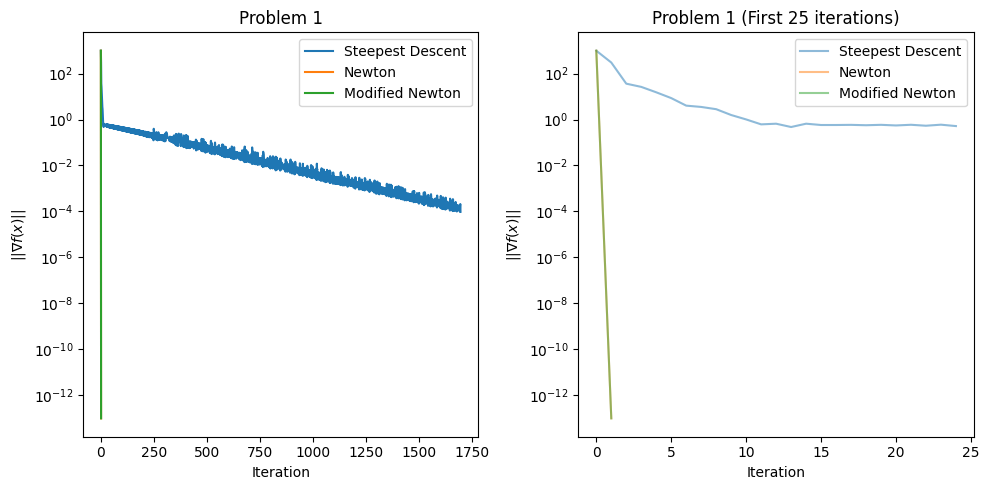

In [8]:
# Problem 1: Extended Rosenbrock function with n = 2, x0 = (-1.2, 1)
n = 2
x0 = np.array([-1.2, 1])

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)


df.loc[len(df)] = ['Problem 1', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 1', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 1', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 1')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 1 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem1.png')
plt.show()


iter  f(x)            ||grad_f(x)||                  alpha          
0     3640.0000000000 3522.2947065798                0.0019531250   
1     681.2185440212  1269.1196418085                0.0019078819   
2     383.7054693560  838.3489238750                 0.0015127580   
3     174.6377691422  530.2942715603                 0.0015362358   
4     92.3364820463   385.3715502420                 0.0014883494   
5     44.0673838735   257.4235940854                 0.0017060628   
6     33.6168982418   264.8636670921                 0.0014443245   
7     29.5950551462   257.8462833055                 0.0012404110   
8     18.8617580592   200.4250484482                 0.0010168007   
9     7.5698401635    99.2654103265                  0.0010799109   
10    4.9316630132    61.6354543199                  0.0009684567   
11    3.6635807371    31.3616447600                  0.0013463751   
12    3.3718428066    30.4741505956                  0.0008605759   
13    3.0348344158    13.229734480

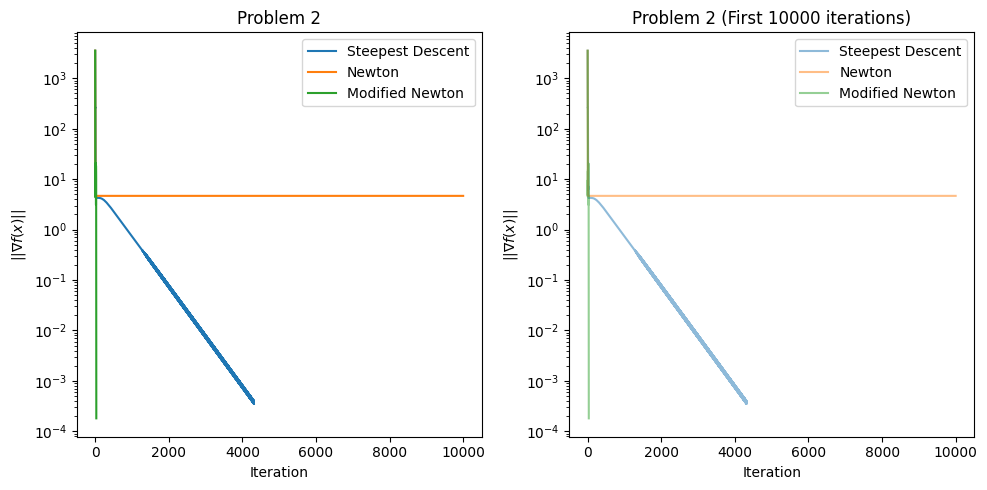

In [6]:
# Problem 2: Extended Rosenbrock function with n = 10, x0 = (-1, ..., -1)

n = 10
x0 = -1 * np.ones(n)

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 2', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 2', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 2', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 2 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem2.png')
plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     3610.0000000000 3779.3173986846                0.0019531250   
1     1144.6832033107 1101.7463855358                0.0027616331   
2     157.9728522194  249.8286527156                 0.0022995903   
3     126.2323951162  208.5088318686                 0.0034553994   
4     120.9395200927  317.4814813086                 0.0022020364   
5     71.1852594874   167.0775496631                 0.0035025876   
6     44.0890007519   165.0121807374                 0.0021650810   
7     24.1594056754   91.4033398979                  0.0026410848   
8     15.8027635587   69.1983891512                  0.0029587983   
9     12.0141895662   62.6715068623                  0.0020890964   
10    9.0281002982    30.5662382691                  0.0028431127   
11    8.3778812191    26.4763585466                  0.0019123689   
12    7.8667497462    10.6533439603                  0.0029787528   
13    7.7976928749    10.456570796

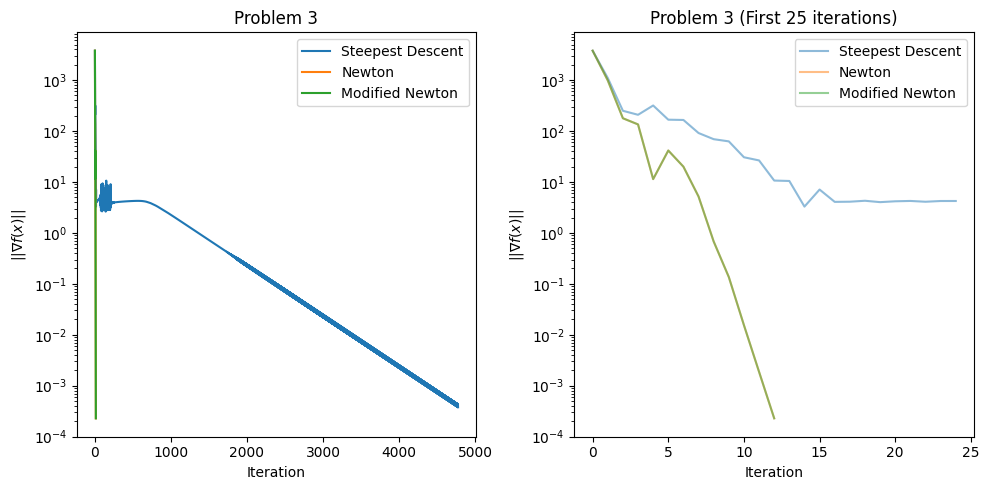

In [7]:
# Problem 3: Extended Rosenbrock function with n = 10, x0 = (2, ..., 2)

n = 10
x0 = 2 * np.ones(n)

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 3', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 3', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 3', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 3')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 3 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem3.png')
plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     40000.0000000000 11952.9075960621               0.0019531250   
1     2724.3242394179 1997.2001690628                0.0020872208   
2     450.2859598464  914.2754967858                 0.0021339106   
3     403.4737474743  841.6195281969                 0.0016402453   
4     199.2073706121  557.6055274480                 0.0013735564   
5     91.4066946141   347.3978501589                 0.0009860090   
6     41.5914070022   154.5660804834                 0.0016352628   
7     31.2287315181   177.5615776060                 0.0010361342   
8     19.1584213075   111.9068044952                 0.0014433262   
9     14.8044338479   125.6730995541                 0.0009409569   
10    9.4024479479    74.1306673718                  0.0014199044   
11    7.8505399551    86.5899876174                  0.0007769107   
12    5.3433156869    36.7520149975                  0.0016813060   
13    4.7496414966    49.35978460

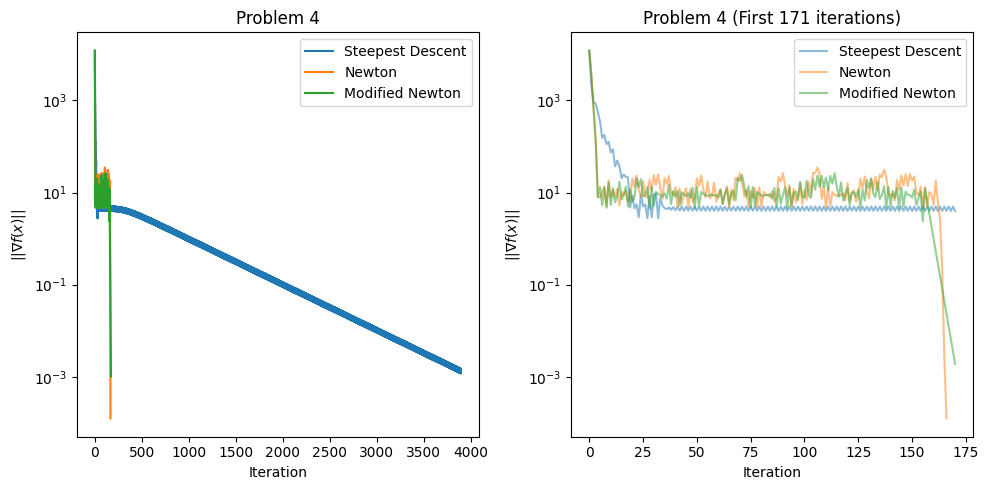

In [8]:
# Problem 4: Extended Rosenbrock function with n = 100, x0 = (-1, ..., -1)

n = 100
x0 = -1 * np.ones(n)

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 4', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 4', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 4', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]


zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 4')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 4 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem4.png')
plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     39700.0000000000 12013.1428027806               0.0019531250   
1     3283.7475099368 1887.5370064632                0.0040374016   
2     1558.4738890989 2053.4773080192                0.0018740670   
3     556.0113760551  342.7077229143                 0.0019820894   
4     501.4437903638  446.3798677816                 0.0018312757   
5     465.2696771975  461.3759943473                 0.0015490127   
6     349.7549342217  272.5383826034                 0.0027369224   
7     287.2355964153  331.2445745603                 0.0024026282   
8     238.8985289632  345.4684235627                 0.0014324722   
9     163.8312830090  138.9070449821                 0.0034303433   
10    128.3704373783  144.8539749470                 0.0020927772   
11    115.9431146505  117.2219583884                 0.0022109748   
12    109.7708223676  109.0186597909                 0.0015872114   
13    103.3338808193  56.47494033

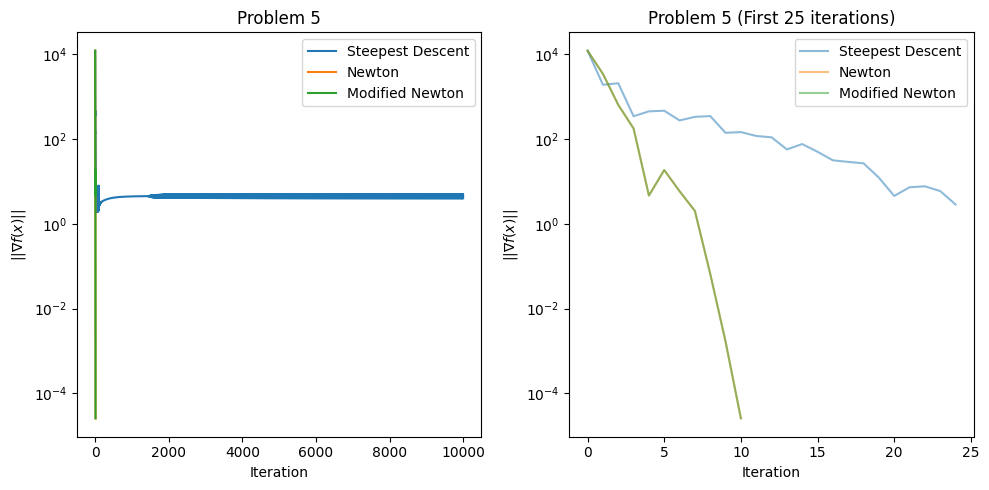

In [9]:
# Problem 5: Extended Rosenbrock function with n = 100, x0 = (2, ..., 2)

n = 100
x0 = 2 * np.ones(n)

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 5', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 5', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 5', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 5')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 5 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem5.png')
plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     400600.0000000000 38008.4095957724               0.0019531250   
1     24674.3905761978 5201.1829883244                0.0041635377   
2     6562.7653597324 2423.4828468447                0.0012562633   
3     5161.1077218596 634.9412889558                 0.0059365124   
4     4335.1649285398 1767.4264216235                0.0013480670   
5     3200.8830155355 629.2980160648                 0.0084173786   
6     1262.2601594191 396.5253663621                 0.0045435339   
7     1073.1210691842 285.5393730914                 0.0041368102   
8     1049.9576483896 216.6273780350                 0.0042922510   
9     1014.2458964343 117.1995019202                 0.0055405054   
10    995.6374650006  47.6824706418                  0.0076411527   
11    991.7432043244  24.8496881728                  0.0070048472   
12    990.0675125142  7.6635455394                   0.0060530411   
13    989.9211569097  2.7100518

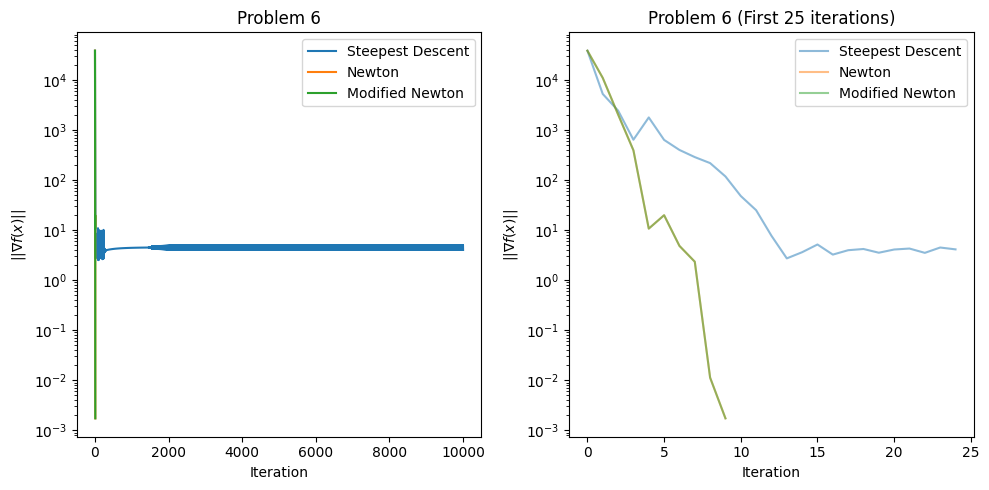

In [10]:
# Problem 6: Extended Rosenbrock function with n = 1000, x0 = (2, ..., 2)

n = 1000
x0 = 2 * np.ones(n)

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 6', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 6', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 6', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 6')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 6 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem6.png')
plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     4009600.0000000000 120199.3144739187              0.0019531250   
1     238580.8212388074 16184.7888386195               0.0083522741   
2     64293.0428819098 46203.0678976400               0.0001555887   
3     2735.4679293887 3761.1168151721                0.0014479439   
4     2640.8756365655 3649.2698024846                0.0011545437   
5     929.0995549506  1786.1947436010                0.0017395810   
6     635.9413440411  1227.0484848840                0.0016506303   
7     401.4506144012  831.0780057590                 0.0029485089   
8     269.6390992841  742.8131296335                 0.0010113171   
9     152.8039088841  401.2360610161                 0.0008178755   
10    94.9679853838   132.0023185139                 0.0017158155   
11    92.2476815148   170.3063988857                 0.0014216862   
12    91.6884732098   195.5285829080                 0.0008475942   
13    79.9492337151   74.583

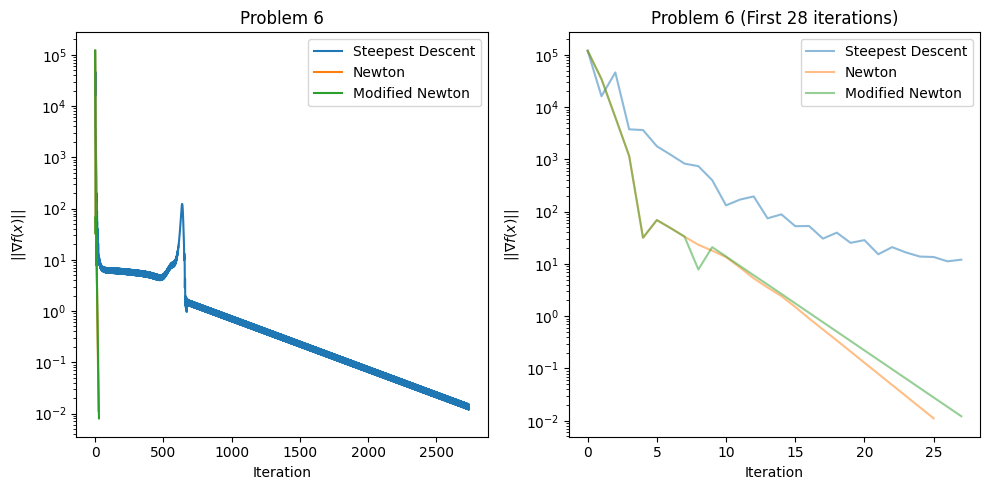

In [11]:
# Problem 7: Extended Rosenbrock function with n = 10000, x0 = (2, ..., 2)

n = 10000
x0 = 2 * np.ones(n)

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_rosenbrock(x, n), 
                                                            lambda x: grad_f_rosenbrock(x, n), 
                                                            lambda x: hessian_f_rosenbrock(x, n), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 7', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 7', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 7', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 6')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 6 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem7.png')
plt.show()

In [12]:
# Beale function
def f_beale(x, y=np.array([1.5, 2.25, 2.625])):
    return (y[0] - x[0] + x[0] * x[1])**2 + (y[1] - x[0] + x[0] * x[1]**2)**2 + (y[2] - x[0] + x[0] * x[1]**3)**2

# Gradient of the Beale function
def grad_f_beale(x, y=np.array([1.5, 2.25, 2.625])):
    df_dx = (2 * (y[0] - x[0] + x[0] * x[1]) * (-1 + x[1]) + 
             2 * (y[1] - x[0] + x[0] * x[1]**2) * (-1 + x[1]**2) + 
             2 * (y[2] - x[0] + x[0] * x[1]**3) * (-1 + x[1]**3))

    df_dy = (2 * (y[0] - x[0] + x[0] * x[1]) * x[0] + 
             2 * (y[1] - x[0] + x[0] * x[1]**2) * (2 * x[0] * x[1]) + 
             2 * (y[2] - x[0] + x[0] * x[1]**3) * (3 * x[0] * x[1]**2))

    return np.array([df_dx, df_dy])

# Hessian of the Beale function
def hess_f_beale(x, y=np.array([1.5, 2.25, 2.625])):
    x1, x2 = x

    H11 = 2 * x2**6 + 2 * x2**4 - 4 * x2**3 - 2 * x2**2 - 4 * x2 + 6
    H12 = 12 * x1 * x2**5 + 8 * x1 * x2**3 - 12 * x1 * x2**2 - 4 * x1 * x2 - 4 * x1 + 15.75 * x2**2 + 9 * x2 + 3
    H21 = H12 
    H22 = 30 * x1**2 * x2**4 + 12 * x1**2 * x2**2 - 12 * x1**2 * x2 - 2 * x1**2 + 31.5 * x1 * x2 + 9 * x1

    H = np.array([[H11, H12],
                  [H21, H22]])

    return H


grad_f_beale(x0) = [ 0.   27.75]
iter  f(x)            ||grad_f(x)||                  alpha          
0     14.2031250000   27.7500000000                  0.0625000000   
1     4.7668598513    4.6112265239                   0.3921246454   
2     1.8761250676    7.6845949071                   0.0866744718   
3     0.8958490950    7.7361115496                   0.0478801173   
4     0.3131506953    2.7887460427                   0.0508373825   
5     0.1052560562    0.4698018382                   1.0516522866   
6     0.0380122731    1.6650441032                   0.0362126709   
7     0.0091785607    0.8060717707                   0.0359003378   
8     0.0043758742    0.4541038911                   0.0257364290   
9     0.0019009623    0.0531574190                   0.0582922794   
10    0.0018403614    0.0674110830                   0.0459885750   
11    0.0017774412    0.0662035091                   0.0376346199   
12    0.0017074411    0.0496993524                   0.0530468207   
1

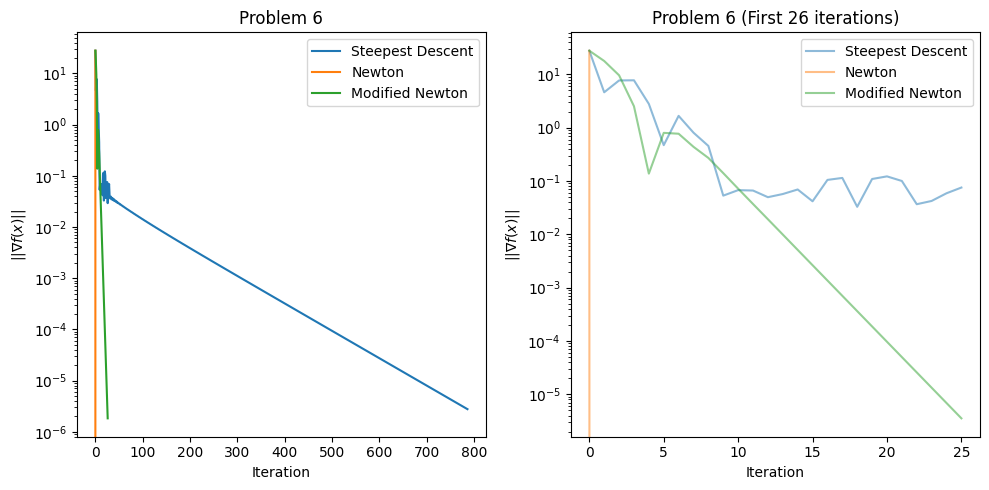

In [13]:
# Problem 8: Beale function with x0 = (1, 1)

x0 = 1 * np.ones(2)
y = [1.5, 2.25, 2.625]

print("grad_f_beale(x0) =", grad_f_beale(x0))

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_beale(x, y), 
                                                            lambda x: grad_f_beale(x, y), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_beale(x, y), 
                                                            lambda x: grad_f_beale(x, y), 
                                                            lambda x: hess_f_beale(x, y), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_beale(x, y), 
                                                            lambda x: grad_f_beale(x, y), 
                                                            lambda x: hess_f_beale(x, y), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 8', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 8', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 8', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 6')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 6 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem8.png')
plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     14.2031250000   12.7500000000                  0.2500000000   
1     4.0429687500    12.5048452523                  0.0625000000   
2     1.3320552409    14.0186410731                  0.0346728079   
3     0.9663074194    6.5072639939                   0.0536760936   
4     0.1554311856    3.4872344125                   0.0445950681   
5     0.0946232729    2.1845672118                   0.0560636005   
6     0.0652187904    2.0068616791                   0.0274752556   
7     0.0144806934    0.1608328207                   0.1146298067   
8     0.0141163309    0.3441586618                   0.0614407982   
9     0.0140607252    0.4043273452                   0.0152818235   
10    0.0121795815    0.2112538741                   0.0470609382   
11    0.0113948046    0.1648607324                   0.0467074587   
12    0.0107746326    0.1359570227                   0.0610662816   
13    0.0102040345    0.1488012838

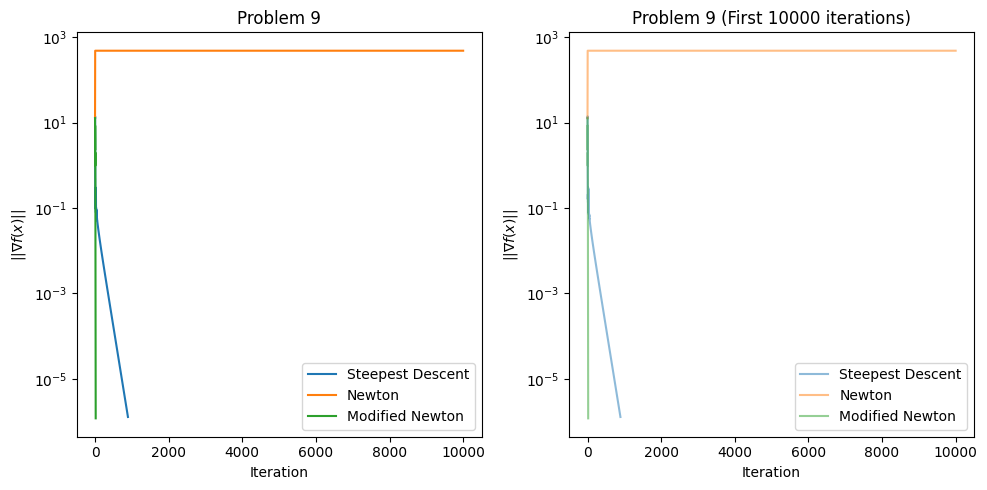

In [14]:
# Problem 9: Beale function with x0 = (0, 0)

x0 = np.zeros(2)

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: f_beale(x, y), 
                                                            lambda x: grad_f_beale(x, y), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: f_beale(x, y), 
                                                            lambda x: grad_f_beale(x, y), 
                                                            lambda x: hess_f_beale(x, y), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: f_beale(x, y), 
                                                            lambda x: grad_f_beale(x, y), 
                                                            lambda x: hess_f_beale(x, y), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 9', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 9', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 9', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 9')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 9 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem9.png')
plt.show()

In [15]:
# Problem 10: 

# f(x) = x_1^2 + \sum_{i=1}^{n-1} (x_{i} - x_{i+1})^{2i}

def function_f(x):
    n = len(x)
    f = x[0]**2 + sum((x[i] - x[i+1])**(2*(i+1)) for i in range(n-1)) +0.0
    return f


def function_f(x):
    """Computes the function value f(x)."""
    n = len(x)
    return x[0]**2 + sum((x[i] - x[i+1])**(2*(i+1)) for i in range(n-1))

def gradient_f(x):
    grad = np.array([
        4*x[0] - 2*x[1],
        -2*x[0] + 2*x[1] + 4*(x[1] - x[2])**3,
        -4*(x[1] - x[2])**3 + 6*(x[2] - x[3])**5,
        -6*(x[2] - x[3])**5 + 8*(x[3] - x[4])**7,
        -8*(x[3] - x[4])**7 + 10*(x[4] - x[5])**9,
        -10*(x[4] - x[5])**9 + 12*(x[5] - x[6])**11,
        -12*(x[5] - x[6])**11 + 14*(x[6] - x[7])**13,
        -14*(x[6] - x[7])**13 + 16*(x[7] - x[8])**15,
        -16*(x[7] - x[8])**15 + 18*(-x[9] + x[8])**17,
        -18*(-x[9] + x[8])**17
    ], dtype=float)
    return grad

def hessian_f(x):
    hess = np.array([
        [4, -2, 0, 0, 0, 0, 0, 0, 0, 0],
        [-2, 12*(x[1] - x[2])**2 + 2, -12*(x[1] - x[2])**2, 0, 0, 0, 0, 0, 0, 0],
        [0, -12*(x[1] - x[2])**2, 12*(x[1] - x[2])**2 + 30*(x[2] - x[3])**4, -30*(x[2] - x[3])**4, 0, 0, 0, 0, 0, 0],
        [0, 0, -30*(x[2] - x[3])**4, 30*(x[2] - x[3])**4 + 56*(x[3] - x[4])**6, -56*(x[3] - x[4])**6, 0, 0, 0, 0, 0],
        [0, 0, 0, -56*(x[3] - x[4])**6, 56*(x[3] - x[4])**6 + 90*(x[4] - x[5])**8, -90*(x[4] - x[5])**8, 0, 0, 0, 0],
        [0, 0, 0, 0, -90*(x[4] - x[5])**8, 90*(x[4] - x[5])**8 + 132*(x[5] - x[6])**10, -132*(x[5] - x[6])**10, 0, 0, 0],
        [0, 0, 0, 0, 0, -132*(x[5] - x[6])**10, 132*(x[5] - x[6])**10 + 182*(x[6] - x[7])**12, -182*(x[6] - x[7])**12, 0, 0],
        [0, 0, 0, 0, 0, 0, -182*(x[6] - x[7])**12, 182*(x[6] - x[7])**12 + 240*(x[7] - x[8])**14, -240*(x[7] - x[8])**14, 0],
        [0, 0, 0, 0, 0, 0, 0, -240*(x[7] - x[8])**14, 306*(-x[9] + x[8])**16 + 240*(x[7] - x[8])**14, -306*(-x[9] + x[8])**16],
        [0, 0, 0, 0, 0, 0, 0, 0, -306*(-x[9] + x[8])**16, 306*(-x[9] + x[8])**16]
    ], dtype=float)
    return hess


iter  f(x)            ||grad_f(x)||                  alpha          
0     10.0000000000   18.8679622641                  0.0625000000   
1     9.2656250000    16.8263186715                  0.0660112360   
2     8.6198492155    14.7955515428                  0.0691059860   
3     8.0327632796    12.7658436032                  0.0776164341   
4     7.7183988663    11.9680738126                  0.0497062097   
5     7.5826653569    18.1346258857                  0.0190646094   
6     6.7101372551    13.6127128568                  0.0173957967   
7     5.5971490782    4.2122952288                   0.0431585528   
8     5.2986008125    3.9186621725                   0.0487326567   
9     5.2503715570    5.0063310388                   0.0322243989   
10    5.0008458926    2.7579174622                   0.0386190230   
11    4.8814962622    2.0848115744                   0.0507887215   
12    4.7957929819    2.2342606500                   0.0485295829   
13    4.7246621950    2.2456603494

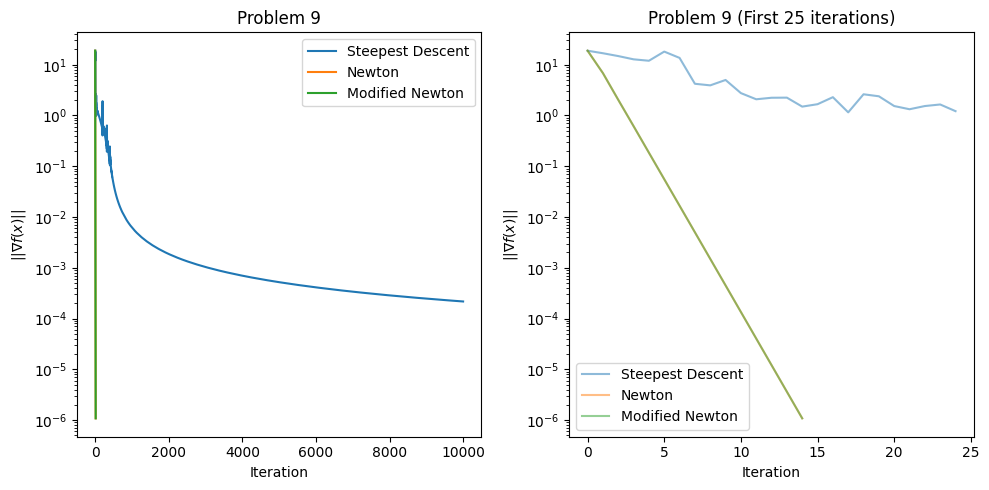

In [16]:
x0 = np.arange(1, 11) + 0.0

# steepest descent method with Armijo backtracking line search
f_steepest, iter_steepest, time_steepest, term_steepest, grad_hist_steepest = steepest_descent_armijo(lambda x: function_f(x), 
                                                            lambda x: gradient_f(x), 
                                                            x0, params)

# Newton's method with Armijo backtracking line search
f_newton, iter_newton, time_newton, term_newton, grad_hist_newton = newton_method_armijo(lambda x: function_f(x), 
                                                            lambda x: gradient_f(x), 
                                                            lambda x: hessian_f(x), 
                                                            x0, params)

# Modified Newton's method with Armijo backtracking line search
f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton, grad_hist_modified_newton = modified_newton_method_armijo(lambda x: function_f(x), 
                                                            lambda x: gradient_f(x), 
                                                            lambda x: hessian_f(x), 
                                                            x0, params)

df.loc[len(df)] = ['Problem 10', 'Steepest Descent', f_steepest, iter_steepest, time_steepest, term_steepest]
df.loc[len(df)] = ['Problem 10', 'Newton', f_newton, iter_newton, time_newton, term_newton]
df.loc[len(df)] = ['Problem 10', 'Modified Newton', f_modified_newton, iter_modified_newton, time_modified_newton, term_modified_newton]

zoom_iterations = max(iter_newton, iter_modified_newton, 25)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(grad_hist_steepest)), grad_hist_steepest, label='Steepest Descent')
plt.plot(range(len(grad_hist_newton)), grad_hist_newton, label='Newton')
plt.plot(range(len(grad_hist_modified_newton)), grad_hist_modified_newton, label='Modified Newton')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title('Problem 9')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grad_hist_steepest[:zoom_iterations], label='Steepest Descent', alpha=0.5)
plt.plot(grad_hist_newton[:zoom_iterations], label='Newton', alpha=0.5)
plt.plot(grad_hist_modified_newton[:zoom_iterations], label='Modified Newton', alpha=0.5)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'Problem 9 (First {zoom_iterations} iterations)')
plt.legend()

plt.tight_layout()

plt.savefig('problem10.png')
plt.show()

In [17]:
# turn dataframe into table
df.style

In [18]:
# save dataframe to csv
df.to_csv('results.csv', index=False)

# save dataframe to latex
df.to_latex('results.tex', index=False)
